In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv


## Goal of the Competition
The goal of this competition is to predict monthly microbusiness density in a given area. You will develop an accurate model trained on U.S. county-level data.

Your work will help policymakers gain visibility into microbusinesses, a growing trend of very small entities. Additional information will enable new policies and programs to improve the success and impact of these smallest of businesses.

## Context
American policy leaders strive to develop economies that are more inclusive and resilient to downturns. They're also aware that with advances in technology, entrepreneurship has never been more accessible than it is today. Whether to create a more appropriate work/life balance, to follow a passion, or due to loss of employment, studies have demonstrated that Americans increasingly choose to create businesses of their own to meet their financial goals. The challenge is that these "microbusinesses" are often too small or too new to show up in traditional economic data sources, making it nearly impossible for policymakers to study them. But data science could help fill in the gaps and provide insights into the factors associated these businesses.

Over the past few years the Venture Forward team at GoDaddy has worked hard to produce data assets about the tens of millions of microbusinesses in the United States. Microbusinesses are generally defined as businesses with an online presence and ten or fewer employees. GoDaddy has visibility into more than 20 million of them, owned by more than 10 million entrepreneurs. We've surveyed this universe of microbusiness owners for several years and have collected a great deal of information on them that you can access via our survey data here.

Current models leverage available internal and census data, use econometric approaches, and focus on understanding primary determinants. While these methods are adequate, there's potential to include additional data and using more advanced approaches to improve predictions and to better inform decision-making.

Competition host GoDaddy is the world’s largest services platform for entrepreneurs around the globe. They're on a mission to empower their worldwide community of 20+ million customers—and entrepreneurs everywhere—by giving them all the help and tools they need to grow online.

Your work will help better inform policymakers as they strive to make the world a better place for microbusiness entrepreneurs. This will have a real and substantial impact on communities across the country and will help our broader economy adapt to a constantly evolving world.


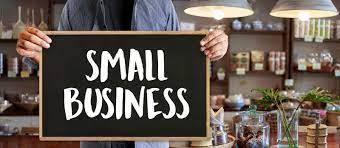

# Dataset explanation:
train.csv
This file contains the following:

row_id - An ID code for the row.

cfips - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.

county - The written name of the county.

state - The name of the state.

first_day_of_month - The date of the first day of the month.

microbusiness_density - Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 2021 density figures are calculated using 2019 population figures, etc.

active - The raw count of microbusinesses in the county. Not provided for the test set.

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
default_color = sns.color_palette()[0]

from sklearn.cluster import KMeans
from sklearn.model_selection import GroupKFold
from sklearn import metrics
from sklearn.model_selection import KFold, TimeSeriesSplit

## The 3 machine learning model
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

## First Let's us underastand all the datasets in deatil

In [3]:
train = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv', parse_dates=['first_day_of_month'])
test = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv', parse_dates=['first_day_of_month'])
sub = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv')
cs_data = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')

In [4]:
print(train.shape)
print(test.shape)
print(sub.shape)
print(cs_data.shape)

(122265, 7)
(25080, 3)
(25080, 2)
(3142, 26)


In [5]:
def smape(y_true, y_pred):
    nume = np.abs(y_true - y_pred)
    deno = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    return 100 * np.mean(nume / deno)

In [6]:
def dataframe(df):
    print(df.head())
    print(df.tail())
    print(df.info())
    for col in df.columns:
        print(df[col].nunique())
        print(df[col].unique())

In [7]:
dataframe(train)

            row_id  cfips          county    state first_day_of_month  \
0  1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1  1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2  1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3  1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4  1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   

   microbusiness_density  active  
0               3.007682    1249  
1               2.884870    1198  
2               3.055843    1269  
3               2.993233    1243  
4               2.993233    1243  
                  row_id  cfips         county    state first_day_of_month  \
122260  56045_2022-06-01  56045  Weston County  Wyoming         2022-06-01   
122261  56045_2022-07-01  56045  Weston County  Wyoming         2022-07-01   
122262  56045_2022-08-01  56045  Weston County  Wyoming         2022-08-01   
122263  56045_2022-09-01  56045  Weston

So far!!
We have data of 122265 rows, no null values, 3135 cfips, 1871 counties, 51 states,39 months ranging from August-2019 to Oct-2022.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='microbusiness_density'>

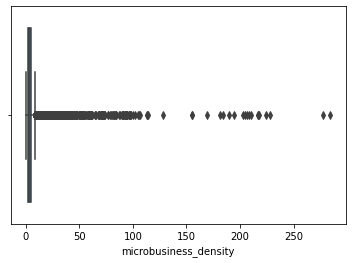

In [8]:
sns.boxplot(train.microbusiness_density)

In [9]:
IQR=train.microbusiness_density.quantile(0.75)-train.microbusiness_density.quantile(0.25)
Upper_limit=train.microbusiness_density.quantile(0.75)+1.5*IQR
Upper_limit
higher_density_states=train[train.microbusiness_density>8.84].state.unique()
lower_density_states=train[train.microbusiness_density<8.84].state.unique()

While the maximum population goes to six figures, the median number is just ~ 5k. Interesting. The million ones must be the metropolitian counties.

In [10]:
train.query("microbusiness_density < 20")["microbusiness_density"].hist(backend="plotly")

We'll be predicting microbusiness densities for various counties for various months. How many counties and how many months? We'll get the answers in the test.csv which contains the meta data relevant to sample_submission.csv

In [11]:
tar_feat = train[['row_id', 'microbusiness_density']]

In [12]:
dataframe(test)

            row_id  cfips first_day_of_month
0  1001_2022-11-01   1001         2022-11-01
1  1003_2022-11-01   1003         2022-11-01
2  1005_2022-11-01   1005         2022-11-01
3  1007_2022-11-01   1007         2022-11-01
4  1009_2022-11-01   1009         2022-11-01
                 row_id  cfips first_day_of_month
25075  56037_2023-06-01  56037         2023-06-01
25076  56039_2023-06-01  56039         2023-06-01
25077  56041_2023-06-01  56041         2023-06-01
25078  56043_2023-06-01  56043         2023-06-01
25079  56045_2023-06-01  56045         2023-06-01
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25080 entries, 0 to 25079
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   row_id              25080 non-null  object        
 1   cfips               25080 non-null  int64         
 2   first_day_of_month  25080 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), objec

So far!! We have data of 25080 rows(20.51% of train data),3 columns, no null values, 3135 cfips(same as train set),8 months ranging from November-2022 to Jun-2023.

# yep!!  we have historical microbusiness densities for a bunch of counties and we have to forecast the same for next 8 months

In [13]:
# randomly select a county
randomly_selected_cfips = train['cfips'].sample(1).iloc[0]
# extract train/test data for the selected county
selected_train_df = train.query(f'cfips == {randomly_selected_cfips}').copy()
selected_test_df = test.query(f'cfips == {randomly_selected_cfips}').copy()

print(f"Randomly selected a county: {randomly_selected_cfips}")

# let's make some random predictions just for fun
random_predictions = np.random.normal(
    selected_train_df["microbusiness_density"].iloc[-1], 0.02, len(selected_test_df)
) 
selected_test_df.loc[:, "microbusiness_density"] = random_predictions


fig = go.Figure()
fig.add_trace(go.Scatter(
    x=selected_train_df["first_day_of_month"], 
    y=selected_train_df["microbusiness_density"],
    mode='lines+markers',
    name="Train Data"))
fig.add_trace(go.Scatter(
    x=selected_test_df["first_day_of_month"], 
    y=selected_test_df["microbusiness_density"],
    mode='markers+text',
    name="To be predicted",
    text=["    ❓ "]*len(selected_test_df),
))

fig.update_layout(
    title_text=f"Cfips: {randomly_selected_cfips}: Train data and Test Data"
)

fig.update_traces(marker=dict(size=5))
fig.update_xaxes(title_text="Year")
fig.update_yaxes(title_text="Microbusiness Density")

fig.show()

Randomly selected a county: 46117


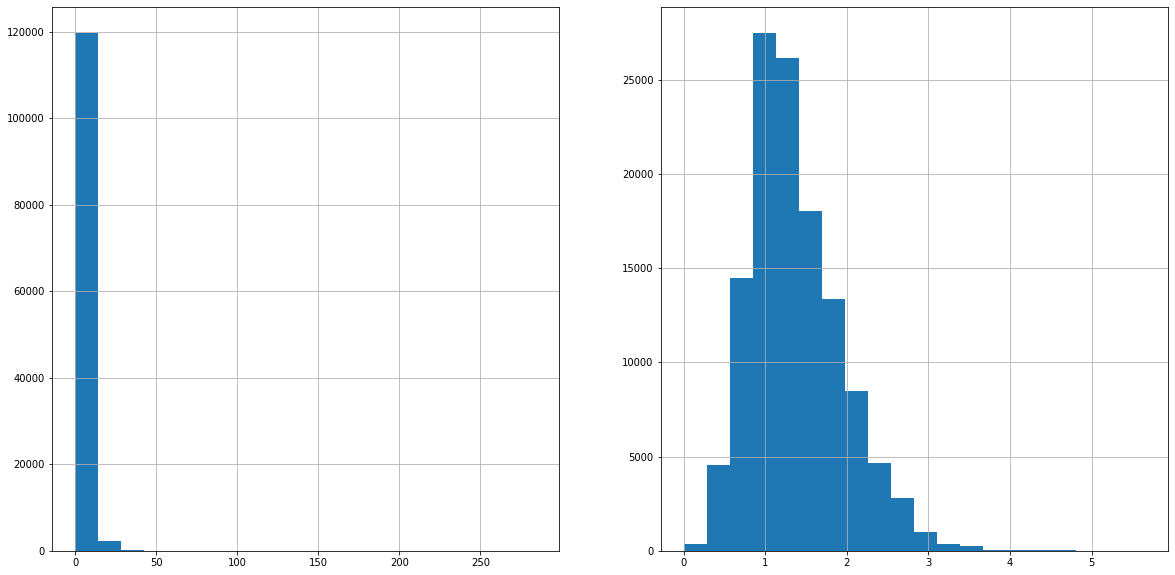

In [14]:
plt.figure(figsize = [20, 10]) 
plt.subplot(1, 2, 1) 
train['microbusiness_density'].hist(bins=20);

plt.subplot(1, 2, 2) # 1 row, 2 cols, subplot 2
(np.log1p(train['microbusiness_density']).hist(bins=20));

# Observation

We observe that the distribution of the original target feature is highly right skewed but after log transformation it becomes to assume a normal distribution which might be a good Distribution when fitting the model

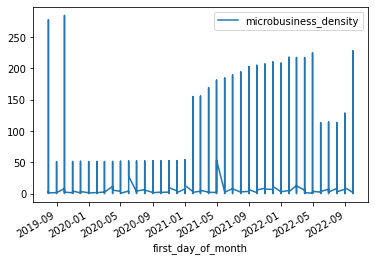

In [15]:
train.plot( 'first_day_of_month' , 'microbusiness_density' );

There seems to be no meaningful trend in the date time data

In [16]:
train['active'].hist(backend='plotly')

Quite skewed!, let's narrow down our focus to only 75 percentile

In [17]:
train[train['active']<train['active'].quantile(0.75)]['active'].hist(backend='plotly')

<AxesSubplot:ylabel='state,active'>

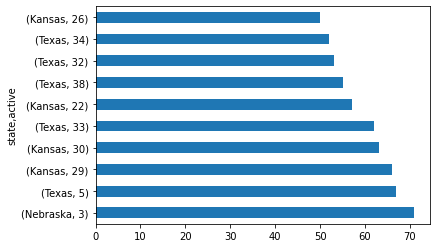

In [18]:
train[['state','active']].value_counts().sort_values(ascending=False).head(10).plot(kind='barh')

Text(0.5, 1.0, 'Top 5 states based on active users')

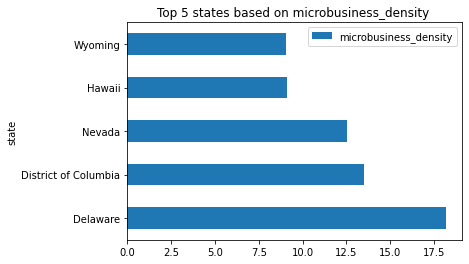

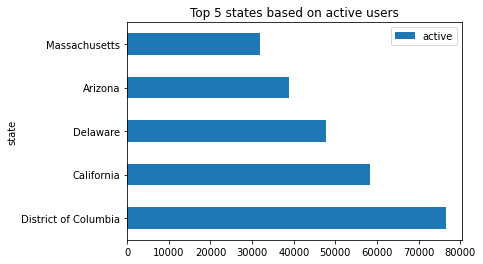

In [19]:
#Top
train.groupby(['state']).mean().reset_index().sort_values('microbusiness_density',ascending=False).head(5).plot(kind='barh',x='state',y='microbusiness_density')
plt.title('Top 5 states based on microbusiness_density ')
train.groupby(['state']).mean().reset_index().sort_values('active',ascending=False).head(5).plot(kind='barh',x='state',y='active')
plt.title('Top 5 states based on active users')

<AxesSubplot:xlabel='microbusiness_density', ylabel='active'>

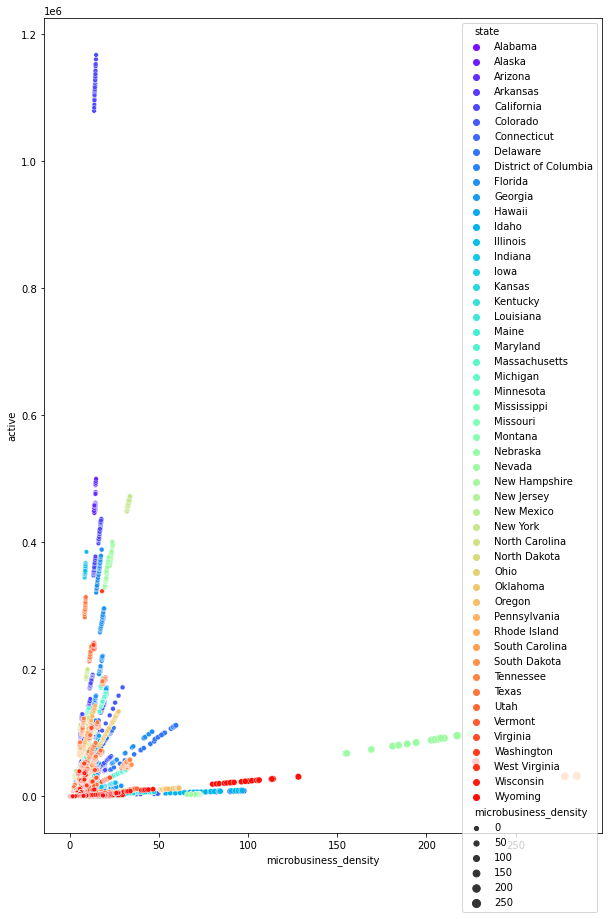

In [20]:
plt.figure(figsize=(10,15))
sns.scatterplot(x='microbusiness_density',y='active',data=train,hue='state',size='microbusiness_density',palette='rainbow')

There is also a census data, let's take a look into it as well!

In [21]:
cs_data.head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,20.6,3.2,3.4,3.7,3.4,3.5,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,6.7,2.7,2.5,2.7,2.6,2.6,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,7.9,1.0,1.4,1.5,1.6,1.1,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,9.3,4.5,4.4,4.5,4.4,4.5,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


pct_bb_[year] - The percentage of households in the county with access to broadband of any type.

cfips - The CFIPS code.
pct_college_[year] - The percent of the population in the county over age 25 with a 4-year college degree.

pct_foreign_born_[year] - The percent of the population in the county born outside of the United States.

pct_it_workers_[year] - The percent of the workforce (16+ y/o) in the county employed in information related industries.

median_hh_inc_[year] - The median household income in the county. Derived from ACS table S1901: INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS).

Before we put census data to analytics, let's restructure it a bit

pct_it_workers are declining while microbusiness_density is increasing

As broad band connectivity increases the microbusiness_density is also growing

In [22]:
### check whether we have the same cfips in the train and test data
test['cfips'].isin(train['cfips']).value_counts()

True    25080
Name: cfips, dtype: int64

In [23]:
cs_data['cfips']

0        1001
1        1003
2        1005
3        1007
4        1009
        ...  
3137    56037
3138    56039
3139    56041
3140    56043
3141    56045
Name: cfips, Length: 3142, dtype: int64

In [24]:
cs_data.nunique()

pct_bb_2017               478
pct_bb_2018               458
pct_bb_2019               435
pct_bb_2020               415
pct_bb_2021               395
cfips                    3142
pct_college_2017          288
pct_college_2018          294
pct_college_2019          299
pct_college_2020          307
pct_college_2021          306
pct_foreign_born_2017     268
pct_foreign_born_2018     265
pct_foreign_born_2019     252
pct_foreign_born_2020     262
pct_foreign_born_2021     269
pct_it_workers_2017        68
pct_it_workers_2018        64
pct_it_workers_2019        68
pct_it_workers_2020        71
pct_it_workers_2021        66
median_hh_inc_2017       2997
median_hh_inc_2018       2995
median_hh_inc_2019       3018
median_hh_inc_2020       3018
median_hh_inc_2021       3024
dtype: int64

In [25]:
### check whether we have the same cfips in the train and census data
cs_data['cfips'].isin(train['cfips']).value_counts()

True     3135
False       7
Name: cfips, dtype: int64

In [26]:
def make_feature(df):
    feature = pd.DataFrame()
    feature["contry_code"] = df["cfips"] // 100
    feature["state_code"] = df["cfips"] % 100
    feature["year"] = df["first_day_of_month"].dt.year
    feature["month"] = df["first_day_of_month"].dt.month
    feature["week"] = df["first_day_of_month"].dt.dayofweek
    
    return feature

In [27]:
train_fe = make_feature(train)
test_fe = make_feature(test)

In [28]:
print(train_fe.shape)
print(test_fe.shape)

(122265, 5)
(25080, 5)


In [29]:
X = train_fe
y = np.log1p(train['microbusiness_density'])

# Catboost Model
CatBoost is a high-performance open source library for gradient boosting on decision trees.

In [30]:
def smape(y_true, y_pred):
    nume = np.abs(y_true - y_pred)
    deno = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    return 100 * np.mean(nume / deno)

In [31]:
errcb=[]
y_pred_totcb=[]
fold= KFold(n_splits=5, shuffle=True, random_state=1)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = CatBoostRegressor(eval_metric='SMAPE')
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)
    preds=m.predict(X_test)
    print("err: ",smape(np.expm1(y_test), np.expm1(preds)))
    errcb.append(smape(np.expm1(y_test), np.expm1(preds)))
    p = m.predict(test_fe)
    y_pred_totcb.append(p)

Learning rate set to 0.104565
0:	learn: 32.7403515	test: 32.7403515	test1: 32.7110530	best: 32.7110530 (0)	total: 67.9ms	remaining: 1m 7s
100:	learn: 27.8191135	test: 27.8191135	test1: 27.9212530	best: 27.9212530 (100)	total: 900ms	remaining: 8.01s
200:	learn: 26.3634029	test: 26.3634029	test1: 26.5204470	best: 26.5204470 (200)	total: 1.72s	remaining: 6.84s
300:	learn: 25.3483633	test: 25.3483633	test1: 25.5482829	best: 25.5482829 (300)	total: 2.56s	remaining: 5.96s
400:	learn: 24.4555474	test: 24.4555474	test1: 24.6845783	best: 24.6845783 (400)	total: 3.41s	remaining: 5.09s
500:	learn: 23.7106265	test: 23.7106265	test1: 23.9448685	best: 23.9448685 (500)	total: 4.29s	remaining: 4.28s
600:	learn: 23.0105159	test: 23.0105159	test1: 23.2586703	best: 23.2586703 (600)	total: 5.14s	remaining: 3.41s
700:	learn: 22.3426972	test: 22.3426972	test1: 22.6115711	best: 22.6115711 (700)	total: 5.98s	remaining: 2.55s
800:	learn: 21.7200395	test: 21.7200395	test1: 22.0003404	best: 22.0003404 (800)	tota

In [32]:
np.mean((errcb))

36.360627299722424

LightGbm Model

In [33]:
params = {
        "metric" : "mse",
        "learning_rate" : 0.2,
         "sub_feature" : 1.0,
        "bagging_freq" : 1,
        "lambda_l2" : 0.6,
        'verbosity': 1,
       'num_iterations' : 3000,        
}

In [34]:
errlgb=[]
y_pred_totlgb=[]
fold= KFold(n_splits=5, shuffle=True, random_state=101)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = LGBMRegressor(**params)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)
    preds=m.predict(X_test)
    print("err: ",smape(np.expm1(y_test), np.expm1(preds)))
    errlgb.append(smape(np.expm1(y_test), np.expm1(preds)))
    p = m.predict(test_fe)
    y_pred_totlgb.append(p)

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] feature_fraction is set with sub_feature=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set with sub_feature=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data

In [35]:
np.mean((errlgb))

5.676309867707912

Conclusion

We observe that Lightgbm is the best Time series model for this problem, with base line feature engineering.

## Extensive Feature Engineering¶

In this section we are going to be using various time series feature engineering techniques

Time series features

Cyclic Time Series features (sin and cos)

Adding the Census data

In [36]:
def make_feature(df):
    feature = pd.DataFrame()
    feature["contry_code"] = df["cfips"] // 100
    feature["state_code"] = df["cfips"] % 100
    feature["year"] = df["first_day_of_month"].dt.year
    feature["month"] = df["first_day_of_month"].dt.month
    feature["week"] = df["first_day_of_month"].dt.dayofweek
    feature['dayofyear'] = df['first_day_of_month'].dt.dayofyear
    feature['dayofmonth'] = df['first_day_of_month'].dt.day
    feature['weekofyear'] = df['first_day_of_month'].dt.weekofyear
    
    return feature


def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [37]:
train_f1 = make_feature(train)
test_f1 = make_feature(test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [38]:
train_f1 = encode(train_f1, 'year', 4)
train_f1 = encode(train_f1, 'month', 12)
train_f1 = encode(train_f1, 'week', 7)

In [39]:
test_f1 = encode(test_f1, 'year', 2)
test_f1 = encode(test_f1, 'month', 12)
test_f1 = encode(test_f1, 'week', 7)

In [40]:
train_f1['cfips'] = train['cfips']
test_f1['cfips'] = test['cfips']
train_f1['row_id'] = train['row_id']
test_f1['row_id'] = test['row_id']

In [41]:
train_f1 = train_f1.merge(cs_data, on=['cfips'])
test_f1 = test_f1.merge(cs_data, on=['cfips'])
test_id = test_f1['row_id']
## Adding the target feature

train_f1 = train_f1.merge(tar_feat, on=['row_id'])

In [42]:
train_f1

,contry_code,state_code,year,month,week,dayofyear,dayofmonth,weekofyear,year_sin,year_cos,month_sin,month_cos,week_sin,week_cos,cfips,row_id,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,microbusiness_density
0,10,1,2019,8,3,213,1,31,-1.000000e+00,8.775837e-14,-8.660254e-01,-5.000000e-01,0.433884,-0.900969,1001,1001_2019-08-01,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,3.007682
1,10,1,2019,9,6,244,1,35,-1.000000e+00,8.775837e-14,-1.000000e+00,-1.836970e-16,-0.781831,0.623490,1001,1001_2019-09-01,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,2.884870
2,10,1,2019,10,1,274,1,40,-1.000000e+00,8.775837e-14,-8.660254e-01,5.000000e-01,0.781831,0.623490,1001,1001_2019-10-01,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,3.055843
3,10,1,2019,11,4,305,1,44,-1.000000e+00,8.775837e-14,-5.000000e-01,8.660254e-01,-0.433884,-0.900969,1001,1001_2019-11-01,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,2.993233
4,10,1,2019,12,6,335,1,48,-1.000000e+00,8.775837e-14,-2.449294e-16,1.000000e+00,-0.781831,0.623490,1001,1001_2019-12-01,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,2.993233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,560,45,2022,6,2,152,1,22,3.263165e-13,-1.000000e+00,1.224647e-16,-1.000000e+00,0.974928,-0.222521,56045,56045_2022-06-01,71.1,73.3,76.8,79.7,81.3,14.1,13.5,13.4,12.7,13.9,3.8,4.1,1.7,2.3,1.6,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0,1.803249
122261,560,45,2022,7,4,182,1,26,3.263165e-13,-1.000000e+00,-5.000000e-01,-8.660254e-01,-0.433884,-0.900969,56045,56045_2022-07-01,71.1,73.3,76.8,79.7,81.3,14.1,13.5,13.4,12.7,13.9,3.8,4.1,1.7,2.3,1.6,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0,1.803249
122262,560,45,2022,8,0,213,1,31,3.263165e-13,-1.000000e+00,-8.660254e-01,-5.000000e-01,0.000000,1.000000,56045,56045_2022-08-01,71.1,73.3,76.8,79.7,81.3,14.1,13.5,13.4,12.7,13.9,3.8,4.1,1.7,2.3,1.6,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0,1.785395
122263,560,45,2022,9,3,244,1,35,3.263165e-13,-1.000000e+00,-1.000000e+00,-1.836970e-16,0.433884,-0.900969,56045,56045_2022-09-01,71.1,73.3,76.8,79.7,81.3,14.1,13.5,13.4,12.7,13.9,3.8,4.1,1.7,2.3,1.6,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0,1.785395


In [43]:
train_f1.drop('row_id',axis=1,inplace=True)
test_f1.drop('row_id',axis=1,inplace=True)
print(train_f1.shape)
print(test_f1.shape)

(122265, 41)
(25080, 40)


In [44]:
X = train_f1.drop('microbusiness_density', axis=1)
y = np.log1p(train_f1['microbusiness_density'])

In [45]:
params = {
        "metric" : "mse", 'num_leaves': 64,
         "sub_feature" : 1.0,
        "bagging_freq" : 1,
        "lambda_l2" : 0.9,
        'verbosity': 1,
       'num_iterations' : 3000,
    
}

In [46]:
errlgb=[]
y_pred_totlgb=[]
fold= KFold(n_splits=5, shuffle=True, random_state=101)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = LGBMRegressor(**params)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)
    preds=m.predict(X_test)
    print("err: ",smape(np.expm1(y_test), np.expm1(preds)))
    errlgb.append(smape(np.expm1(y_test), np.expm1(preds)))
    p = m.predict(test_f1)
    y_pred_totlgb.append(p)

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] feature_fraction is set with sub_feature=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set with sub_feature=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5896
[LightGBM] [Info] Number of data points in the train set: 97812, number of used features: 39
[L

In [47]:
d = {"row_id": test_id, 'microbusiness_density': abs(np.expm1(np.mean(y_pred_totlgb, 0)))}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["row_id", 'microbusiness_density']]

In [48]:
test_predictions.to_csv("submission.csv", index=False)

In [49]:
test_predictions.describe()

,microbusiness_density
count,25080.000000
mean,3.919756
std,5.190168
min,0.003644
25%,1.673441
50%,2.620506
75%,4.590866
max,131.296906


In [50]:
test_predictions

,row_id,microbusiness_density
0,1001_2022-11-01,3.426240
1,1001_2022-12-01,3.447273
2,1001_2023-01-01,3.269450
3,1001_2023-02-01,3.302657
4,1001_2023-03-01,3.321367
...,...,...
25075,56045_2023-02-01,1.761801
25076,56045_2023-03-01,1.772236
25077,56045_2023-04-01,1.759838
25078,56045_2023-05-01,1.790272
